In [1]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [2]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")

In [8]:
from langchain_core.messages import convert_to_messages
from langgraph.prebuilt import create_react_agent
import matplotlib.pyplot as plt
import pandas as pd

In [4]:

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [ ]:
def plot_bar_chart(filepath: str, category_col: str, value_col: str):
    """Create a bar chart comparing values across categories."""
    df = pd.read_csv(filepath)
    df.plot(kind='bar', x=category_col, y=value_col, legend=False)
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.title(f"{value_col} by {category_col}")
    plt.tight_layout()
    plt.show()

def plot_line_chart(filepath: str, x_col: str, y_col: str):
    """Create a line chart to visualize a trend over time."""
    df = pd.read_csv(filepath)
    df.plot(kind='line', x=x_col, y=y_col, marker='o')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} over {x_col}")
    plt.tight_layout()
    plt.show()

def plot_histogram(filepath: str, column: str, bins: int = 10):
    """Create a histogram to show the distribution of a numerical variable."""
    df = pd.read_csv(filepath)
    plt.hist(df[column], bins=bins, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column}")
    plt.tight_layout()
    plt.show()

def plot_scatter_plot(filepath: str, x_col: str, y_col: str):
    """Create a scatter plot to visualize correlation between two variables."""
    df = pd.read_csv(filepath)
    plt.scatter(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")
    plt.tight_layout()
    plt.show()

def preview_csv_file(filepath: str, n: int = 5) -> str:
    """Preview the first n rows of a CSV file as a string."""
    df = pd.read_csv(filepath)
    return df.head(n).to_string(index=False)

charts_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[plot_bar_chart, plot_line_chart, plot_histogram, plot_scatter_plot, preview_csv_file],
    prompt=(
    "You are a data analyst agent.\n\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with data analysis tasks (e.g., previewing CSVs and mainly plotting charts)\n"
    "- Use the available tools to load and visualize data from the data folder\n"
    "- After you're done with your tasks, respond to the supervisor directly\n"
    "- Respond ONLY with the results of your work (e.g., charts, data summaries), do NOT include ANY other text."
    ),
    name="charts_agent",
)

In [12]:
def dummy_tool(filepath: str) -> str:
    """Analyze the data context and comment on it."""
    df = pd.read_csv(filepath)
    return df.to_string(index=False)

dummy_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[dummy_tool],
    prompt=(
        "You are a data commenting agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your ONLY task is to review and comment on the contents of uploaded CSV files\n"
        "- Use the available tools to load and inspect the data from the 'data/' folder\n"
        "- Your comment should summarize the structure, contents, and any noticeable patterns in the dataset\n"
        "- DO NOT generate charts, perform calculations, or answer unrelated questions\n"
        "- Respond ONLY with your comment or insight—NO extra formatting, headers, or explanations"
    ),
    name="dummy_agent",
)

#### Langgraph workflow

In [13]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[charts_agent, dummy_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a charts agent. Assign data analysis tasks to this agent\n"
        "- a dummy agent. Assign commenting tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

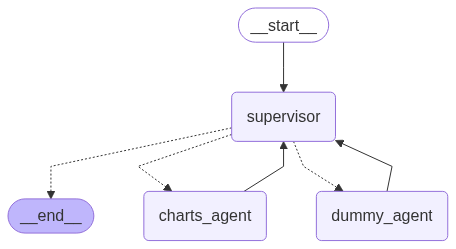

In [14]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

#### Quick testing

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Plot a line chart of the 'sales' column over 'date' in the 'data/monthly_financials.csv' file.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_charts_agent

Successfully transferred to charts_agent


Update from node charts_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The charts agent was unable to find the file 'data/sales_data.csv'. Please confirm the filename and its location, or provide the correct file path so the charts agent can continue with the task.


